Code to compute longitude offsets between 2.5 Rs and 1 AU HCS crossings per the methodology of paper

In [1]:
# Do our imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('nbagg')
from scipy.special import expit

import datetime

import heliopy.data.omni as omni

from sunpy.coordinates import sun,frames,ephemeris
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as const
from sunpy.sun import constants as con

from DL_GONG import DL_GONG
import sunpy 
import pfsspy
from pfsspy import tracing
from pfsspy import coords
from spin_angle import re_angle,re_angle_deg



In [2]:
# these study start and end times are based on GONG availability
startdate = datetime.datetime(2006,9,20,0)
enddate = datetime.datetime(2021,1,1,0)

# Omni data HCS identification #

In [80]:
# Code to read in or download the hourly OMNI data. 

download = False # are we going to have to download new files or do we already have them?

if download:
    dat = omni.h0_mrg1hr(startdate,enddate).to_dataframe()
    eartheph = ephemeris.get_earth(time=dat.index)
    dat['CarLat']= eartheph.lat.value
    dat['r'] = eartheph.radius.value
    
    # these ephemeris calls are s l o w !
    dat['CarLon']=sun.L0(time=dat.index).value
    dat['CR'] = np.floor(sun.carrington_rotation_number(dat.index)).astype(int)
    dat.to_hdf('omni_2006_21.hdf',key='df',mode='w')
else:
    dat = pd.read_hdf('omni_2006_21.hdf') # this is a pre-made file 

# some duplicate times exist in the omni data so chuck those
dat = dat.loc[~dat.duplicated(keep='first')]


dat['B_angle'] = np.arctan2( dat.BX_GSE,dat.BY_GSE )*180./np.pi #-45 is + Br parker spiral, 135 is -ve Br.
dat['Parker_angle'] = np.arctan2( (con.get('sidereal rotation rate')*const.au),dat.V.values*u.km*u.rad/u.s).to(u.deg).value
dat['dParker'] = dat.B_angle +dat.Parker_angle # angle from nominal Parker spiral angle of 45 degrees
dat['dParker'] = re_angle_deg(dat.dParker.values,-180,180) # make this angle go from - to + 180
dat['park_pol'] = np.ones(dat.B_angle.size) # define the polarity relative to the Parker spiral
dat['park_pol'].iloc[abs(dat.dParker.values) > 90 ] = -1

C:\Users\sj919119\OneDrive - University of Reading\Code\Mapping_Paper_Code\spin_angle.py:13: RuntimeWarning: invalid value encountered in less
  under = (ang_in < low)
C:\Users\sj919119\OneDrive - University of Reading\Code\Mapping_Paper_Code\spin_angle.py:14: RuntimeWarning: invalid value encountered in greater
  over =  (ang_in > high)
<ipython-input-80-d7960882dce8>:27: RuntimeWarning: invalid value encountered in greater
  dat['park_pol'].iloc[abs(dat.dParker.values) > 90 ] = -1
C:\Users\sj919119\AppData\Local\Continuum\anaconda3\envs\heliomapsk\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [19]:
# We're going to use the HCS list from leif svalgaard http://wso.stanford.edu/SB/SB.Svalgaard.html. This only gives crossing dates
# I will use these as a starting point to check for a precise crossing time within

# code to read the txt file
cols= ['pre','post','year','month','day','pretime','posttime']
HCS_Dates = pd.read_csv('sblist.txt',names=cols,sep = '\s+|,|\t')
datedf = HCS_Dates[['year','month','day']]

# create the dataframe
sec_df =pd.to_datetime(datedf)
sec_df = pd.DataFrame({'pretime':HCS_Dates['pretime'].values,'posttime':HCS_Dates['posttime'].values,'flip':HCS_Dates['pre'].values},index=sec_df)

# define carrington longitude and carrington number from the time using sunpy
sec_df['CarLon']=sun.L0(time=sec_df.index).value
sec_df['CR'] = np.floor(sun.carrington_rotation_number(sec_df.index)).astype(int)

# reduce the dataframe only to times we have data
sec_df = sec_df.iloc[sec_df.index > startdate]

# add a variable that defines the sign change of the sector crossing
sec_df['flip_int']=np.zeros(sec_df.flip.size).astype(int)
sec_df['flip_int'].iloc[sec_df.flip.values=='+']=1
sec_df['flip_int'].iloc[sec_df.flip.values=='-']=-1


<ipython-input-19-9caf7901ca34>:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  HCS_Dates = pd.read_csv('sblist.txt',names=cols,sep = '\s+|,|\t')


In [ ]:
# define a v for each crossing using the omni data in a 24 hour centred window

for t in sec_df.index: # do a loop
    ind = abs(t-dat.index) < pd.Timedelta(days=.5) # pick index in window
    sec_df.loc[t,'V'] = dat.V[ind].mean() # find mean v
    sec_df.loc[t,'n_in_V'] = np.sum(ind) # number of samples in v
    sec_df.loc[t,'n'] = dat.N[ind].mean() 
    sec_df.loc[t,'B'] = dat.ABS_B[ind].mean() 
    sec_df.loc[t,'Br'] = abs(dat.BX_GSE[ind]).mean()
    ind_cen = np.argmin(abs(t - dat.index))
    
    # also calcualte velocity gradient although I don't use it any more
    ind_plus = np.arange(ind_cen,ind_cen+12) # this works since it's 12 hour
    ind_minus = np.arange(ind_cen-12,ind_cen)
    sec_df.loc[t,'Vgrad'] = dat.V[ind_plus].mean() - dat.V[ind_minus].mean() # so for increasing V, this will be positive

In [96]:
# use a logistic regression approach to get a most probable HCS location

from sklearn.linear_model import LogisticRegression


def flip_finder(df, dat,rm_perp=False,rm_perp_limit=30,nday = 2):
    '''Code to find the best fitting current sheet crossing location/time
    df is my sector data
    dat is my omni data
    rm_perp: optionally discount samples with dParker angle within rm_perp_limit degrees of 90
    nday: number of days either side of the date in df to look for the crossing within
    '''
    bad6 = np.zeros(df.shape[0]) # create an empty array to flag if something fails
    
    i=0 # bad loop design
    for index,entry in df.iterrows(): # iterate over each crossing in df
        fliptype = entry.flip_int
        day_offset = 6/24. # an offset to accoutnt for when the flip is likely to happen in the day. if they give the date it isn't going to be at midnight on average
        
        # pull out relevant part of the omni data:
        subdat_index = ( dat.index.floor('D')>=  index.floor('D')-pd.Timedelta(days=nday -day_offset) )  & ( dat.index.floor('D') <=  index.floor('D')+pd.Timedelta(days=nday+day_offset)  )
        subdat = dat.iloc[subdat_index]
        
        if subdat_index.sum()>1: # only continue if there are > 1 omni data points available
            t = (subdat.index-subdat.index[0]).total_seconds().values # this is the time relative to the window
            y= subdat.park_pol.values # we'll be fitting the polarity as a logistic function
            tmax= np.max(t) 
            t=t/tmax # normalise time between 0 and 1, which is needed by the regression
            
            # do the removal of samples that are too close to ambiguous polarity
            if rm_perp:
                ydrop = ( abs(subdat.dParker.values) > 90-rm_perp_limit) & (abs(subdat.dParker.values) < 90 + rm_perp_limit)
                y=y[~ydrop]
                t=t[~ydrop]
    
            if np.any(y==1) and np.any(y==-1): # so if it's not all ones or zeros (i.e., there's an actual change in polarity)
                clf = LogisticRegression(solver='liblinear',C=10000).fit(t.reshape(-1, 1) , y) # do the regression fit
                
                # extract and save properties of the regression fit
                df.loc[index,'coef'] =clf.coef_[0][0] 
                df.loc[index,'intercept']=clf.intercept_[0]
                df.loc[index,'score'] = clf.score(t.reshape(-1,1),y)
                
                df.loc[index,'t_c'] = (-clf.intercept_[0]/clf.coef_[0][0]) # crossing time in seconds
                df.loc[index,'t_cross'] = pd.Timedelta(seconds=(-clf.intercept_[0]/clf.coef_[0][0])*tmax) + subdat.index[0] # crossing time in datetime, from adding the first time index back in
                df.loc[index,'frac_pos'] = np.sum(y>0)/(np.sum(y!=0)) # fraction of samples which are positive polarity
                df.loc[index,'frac_valid'] = np.sum(y!=0)/(24*2*nday) # fraction which are valid (out of possible total)
                fitflip = expit(clf.coef_[0][0]*t + clf.intercept_[0])[-1]-expit(clf.coef_[0][0]*t + clf.intercept_[0])[0] > 0 # boolean to indicate which direction the polarity flips
                if fitflip:
                    df.loc[index,'fit_flip'] = -1 # and record that as -1 or +1
                else:
                    df.loc[index,'fit_flip'] = 1
            else:
                bad6[i]=True # if there's not then set this flag
        i+=1
    df['hrs_offset'] = (df.t_cross-(df.index + pd.Timedelta(day_offset) )).values/ np.timedelta64(1, 'h') # compute how far the crossing time is from the original date
    
    
    # also figure out if the result is good or bad
    P = 27.2752612 # solar rotation period in days as seen from Earth. We use synodic period here
    lon_offset = 360*(df.hrs_offset/24)/P

    # conditions for throwing away data:
    bad1 = abs(df.hrs_offset)> 48 # can't predict crossing time outside of the window
    bad2 = df.score<.8 # limit based on how good the regression is
    bad3 = (df.frac_pos > .9) | (df.frac_pos < .1) # can't predict too much of one polarity
    bad4 = df.frac_valid<.5 # need at least 50% of data filled in
    bad5 = np.isnan(df.frac_valid.values.astype(float)) # also if the valid parameter is NaN
    rem = bad1 | bad2 | bad3 | bad4 | bad5 | bad6  # combine them all with inclusive or 
    lon_offset[rem]=np.nan

    df['lon_cross'] = sun.L0(time=sec_df.t_cross).value # crossing longitude from epehemeris to be safe
    df['lon_cross'][rem] = np.nan
    return(df,rem)

In [97]:
# call the flip finder code with my options

rm_perp=True
rm_perp_limit = 25   
nday = 3

sec_df,rem = flip_finder(sec_df,dat,rm_perp=rm_perp,rm_perp_limit=rm_perp_limit,nday=nday)

<ipython-input-96-01167935513c>:32: RuntimeWarning: invalid value encountered in greater
  ydrop = ( abs(subdat.dParker.values) > 90-rm_perp_limit) & (abs(subdat.dParker.values) < 90 + rm_perp_limit)
<ipython-input-96-01167935513c>:32: RuntimeWarning: invalid value encountered in less
  ydrop = ( abs(subdat.dParker.values) > 90-rm_perp_limit) & (abs(subdat.dParker.values) < 90 + rm_perp_limit)
<ipython-input-96-01167935513c>:32: RuntimeWarning: invalid value encountered in greater
  ydrop = ( abs(subdat.dParker.values) > 90-rm_perp_limit) & (abs(subdat.dParker.values) < 90 + rm_perp_limit)
<ipython-input-96-01167935513c>:32: RuntimeWarning: invalid value encountered in less
  ydrop = ( abs(subdat.dParker.values) > 90-rm_perp_limit) & (abs(subdat.dParker.values) < 90 + rm_perp_limit)
<ipython-input-96-01167935513c>:32: RuntimeWarning: invalid value encountered in greater
  ydrop = ( abs(subdat.dParker.values) > 90-rm_perp_limit) & (abs(subdat.dParker.values) < 90 + rm_perp_limit)
<ipyth

<IPython.core.display.Javascript object>


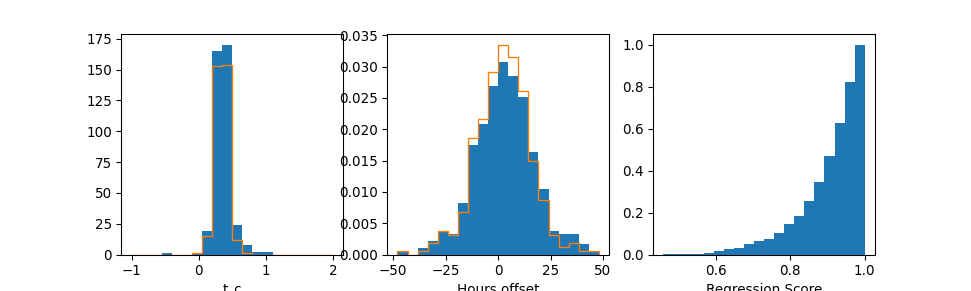

Text(0.5, 0, 'Regression Score')

In [98]:
# just having a look at the crossing times and making sure my removal is working
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.hist(sec_df.t_c,range=[-1,2],bins=20)
plt.hist(sec_df.t_c.values[~rem],range=[-1,2],bins=20,histtype='step')
plt.xlabel('t_c')
plt.subplot(132)
plt.hist(sec_df.hrs_offset.values,range=[-48,48],bins=20,density=True)
plt.hist(sec_df.hrs_offset.values[~rem],range=[-48,48],bins=20,density=True,histtype='step')
plt.xlabel('Hours offset')
plt.subplot(133)
plt.hist(sec_df.score.values,bins=20,cumulative=True,density=True)
plt.xlabel('Regression Score')

<IPython.core.display.Javascript object>


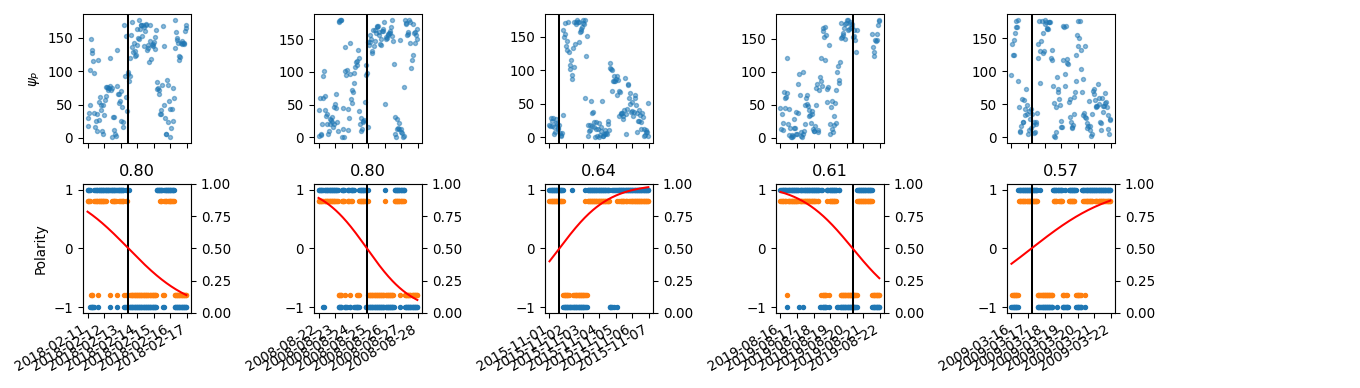

<ipython-input-102-62d783df6dff>:29: RuntimeWarning: invalid value encountered in greater
  ydrop = ( abs(subdat.dParker.values) > 90-rm_perp_limit) & (abs(subdat.dParker.values) < 90 + rm_perp_limit)
<ipython-input-102-62d783df6dff>:29: RuntimeWarning: invalid value encountered in less
  ydrop = ( abs(subdat.dParker.values) > 90-rm_perp_limit) & (abs(subdat.dParker.values) < 90 + rm_perp_limit)


In [102]:
# An example plot of how the regression works for some low scores
from numpy.random import choice 

sec_df_sub = sec_df.iloc[sec_df.score.values<0.8]

indexes = np.arange(0,sec_df_sub.index.size).astype(int)

ind = choice(indexes,size=5)


fig= plt.figure(figsize=(14,4))
i=1
for index,entry in sec_df_sub.iloc[ind].iterrows():
    fliptype = entry.flip_int
    day_offset = 6/24. # an offset to accoutnt for when the flip is likely to happen in the day
    subdat_index = ( dat.index.floor('D')>=  index.floor('D')-pd.Timedelta(days=nday -day_offset) )  & ( dat.index.floor('D') <=  index.floor('D')+pd.Timedelta(days=nday+day_offset)  )
    subdat = dat.iloc[subdat_index]
    t = (subdat.index-subdat.index[0]).total_seconds().values
    tmax= np.max(t)
    t=t/tmax

    ax=plt.subplot(2,6,i)
    y= subdat.park_pol
    plt.plot(abs(subdat.dParker),'.',alpha=.5)
    plt.axvline(entry.t_cross,color='k')
    if i ==1: plt.ylabel('$\psi_P$')
    ax2=plt.subplot(2,6,i+6)
    y= subdat.park_pol
    ydrop = ( abs(subdat.dParker.values) > 90-rm_perp_limit) & (abs(subdat.dParker.values) < 90 + rm_perp_limit)
    plt.plot(subdat.index,y,'.')
    plt.plot(subdat.index[~ydrop],y[~ydrop]*.8,'.')
    if i == 1: plt.ylabel('Polarity')
    plt.axvline(entry.t_cross,color='k')
    ax3=ax2.twinx()
    plt.plot(subdat.index,expit(entry.coef*t+entry.intercept),color='r')
    plt.title(f'{entry.score:.2f}')
    plt.ylim(0,1)
    i+=1
fig.autofmt_xdate()
plt.tight_layout()

<IPython.core.display.Javascript object>


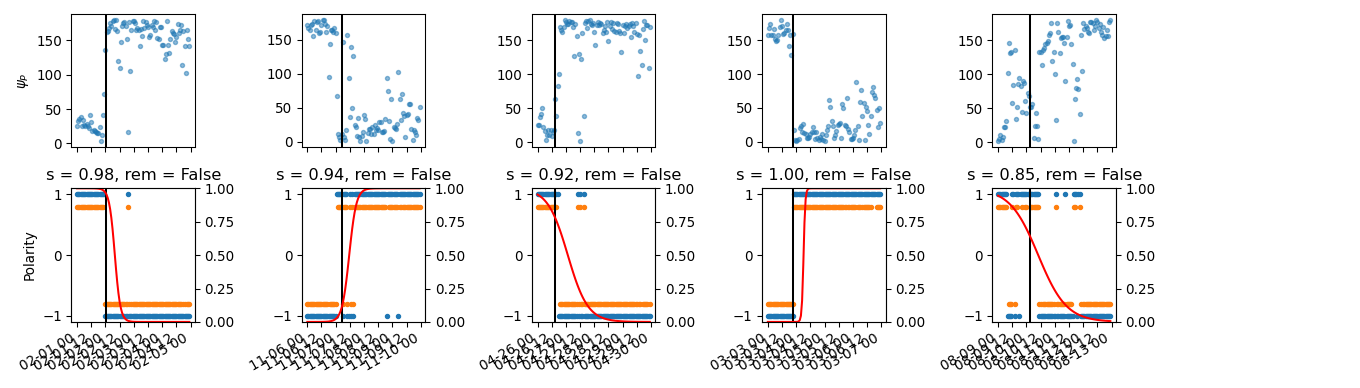

In [106]:
# choose some random crossings to plot, which have characteristically good or bad scores. I also print whether they're removed

sec_df_sub = sec_df.iloc[sec_df.score.values>0.8]
rem_sub = rem[sec_df.score.values>0.8]
indexes = np.arange(0,sec_df_sub.index.size).astype(int)

ind = choice(indexes,size=5)

fig = plt.figure(figsize=(14,4))
i=1
for index,entry in sec_df_sub.iloc[ind].iterrows():
    fliptype = entry.flip_int
    day_offset = 6/24. # an offset to accoutnt for when the flip is likely to happen in the day
    subdat_index = ( dat.index.floor('D')>=  index.floor('D')-pd.Timedelta(days=2 -day_offset) )  & ( dat.index.floor('D') <=  index.floor('D')+pd.Timedelta(days=2+day_offset)  )
    subdat = dat.iloc[subdat_index]
    t = (subdat.index-subdat.index[0]).total_seconds().values
    tmax= np.max(t)
    t=t/tmax
    ax=plt.subplot(2,6,i)
    y= subdat.park_pol
    plt.plot(abs(subdat.dParker),'.',alpha=.5)
    plt.axvline(entry.t_cross,color='k')
    if i ==1: plt.ylabel('$\psi_P$')
    ax2=plt.subplot(2,6,i+6)
    if i == 1: plt.ylabel('Polarity')
    y= subdat.park_pol
    ydrop = ( abs(subdat.dParker.values) > 90-rm_perp_limit) & (abs(subdat.dParker.values) < 90 + rm_perp_limit)
    plt.plot(subdat.index,y,'.')
    plt.plot(subdat.index[~ydrop],y[~ydrop]*.8,'.')
    plt.axvline(index+  pd.Timedelta(hours=entry.hrs_offset),color='k')
    ax3=ax2.twinx()
    plt.plot(subdat.index,expit(entry.coef*t+entry.intercept),color='r')
    plt.title(f's = {entry.score:.2f}, rem = {rem_sub.values[ind[i-1]]}')
    plt.ylim(0,1)
    i+=1
fig.autofmt_xdate()

plt.tight_layout()

# Magnetogram and PFSS HCS identification # 

In [109]:
class magnetogram:
    '''Class to contain magnetograms from GONG
    magnetogram.CR = carrington rotation
    magnetogram.time = time used to call gong map
    magnetogram.gongbr = br data from gong map
    magnetogram.gonghead = gong header
    
    '''
    def __init__(self,time,specify=False):
        self.time = time
        if specify== False:
            br,head = DL_GONG(time.to_pydatetime(),datetype='datetime')
        if specify:
            fname = './GONG/gong'+time[0:4]+time[5:7]+time[8:10]+'.fits'
            [[br, head]] = sunpy.io.fits.read(fname)
            # this is the radial component of the field. The adjustments are based on pfsspy examples.
            br = br - np.nanmean(br) 
            br = np.roll(br, head['CRVAL1'] + 180, axis=1)
        if br.size>1:
            self.gongbr,self.gonghead = br,head
        else:
            self.gonghead = 'No file'


In [111]:
# now I want to produce and save some pfss solutions to my new dataframe. Then I can save them. This takes a long time

# make a pfss class that holds the pfss model output, magnetogram time, source surface height
class pfss:
    '''Class to contain pfss objecs and data
    pfss.CR = carrington rotation 
    pfss.gonghead = gong header file
    pfss.input = pfsspy input object
    pfss.output = pfsspy output object
    pfss.ssbr = source surface magnetic field
    pfss.phi = phi grid edges. phi is carrington longitude I think.
    pfss.costheta = cos theta grid edges. theta is regular latitude I think
    pfss.theta = theta grid edges. theta is  colatitude
    pfss.lat = real latitude grid edges
    '''
    def __init__(self,time,br,header,rss):
        # these choices come from the pfsspy examples.
        nr = 60
        self.gonghead = header 
        m = sunpy.map.Map(br,header) # make a map from gong data
        self.input = pfsspy.Input(m,nr,rss) # set up the pfss input
        self.output = pfsspy.pfss(self.input) # this is the code that computes the PFSS solution
        self.ssbr = self.output.source_surface_br.data # pull out source surface field 2d array
        
        # these are the coordinates of the array
        self.phi = self.output.grid.pg 
        self.costheta = self.output.grid.sg
        self.theta = np.arccos(self.costheta)
        # theta is colatitude
        self.lat = -self.theta + np.pi/2

In [112]:
# function to open saved PFSS files
def open_pfss_from_t(time):
    datestr = time.translate({ord(i):None for i in ':'})
    p = pd.read_hdf('./PFSS_HDFs/pfss_'+datestr+'.hdf',key='2pt5')
    if type(p.pfss_2pt5) is np.ndarray: 
        p = p.pfss_2pt5[1]
    elif type(p.pfss_2pt5) is type(None):
        p=None
    else:
        p = p.pfss_2pt5
    return(p)

In [113]:
import os.path

# code for if I'm doing a new PFSS file
def solve_new_pfss(df_gong_in,write=True): # df_gong is my magnetogram/pfss dataframe
    df_gong=df_gong_in.copy() # this is to avoid overwriting by accident
    df_gong['pfss_2pt5'] = '' # pre-define the pfss variable
    
    # iterate over each entry
    for ind in df_gong.index:
        entry = df_gong.loc[ind].copy()
        mag = magnetogram(entry.gongtime,specify=True) # put the magnetogram into the dataframe. I'm assuming the file already local I think
        datestr = entry.gongtime.translate({ord(i):None for i in ':'}) # translate the time into pfss name string
        pfssname = './PFSS_HDFs/pfss_'+datestr+'.hdf'
        if os.path.isfile(pfssname): # if we have the solution then open it
            df_gong.loc[ind,'pfss_2pt5'] =  pd.read_hdf('./PFSS_HDFs/pfss_'+datestr+'.hdf',key='2pt5').values
        else: # if we don't then compute it using the class instance
            df_gong.loc[ind,'pfss_2pt5'] = pfss(pd.to_datetime(mag.gonghead['DATE']).to_pydatetime(),mag.gongbr,mag.gonghead,2.5)
            if write:
                df_gong.loc[ind].to_hdf('./PFSS_HDFs/pfss_'+datestr+'.hdf',key='2pt5',mode='w') # and we can write what we computed
    return(df_gong)
    

def read_pfss(df_gong_in): # function to read in pfss stuff and place it into df_gong
    df_gong=df_gong_in.copy() 
    df_gong['pfss_2pt5']=''
    for index,row in df_gong.iterrows(): 
        datestr = row.gongtime.translate({ord(i):None for i in ':'})
        df_gong.loc[index] = pd.read_hdf('./PFSS_HDFs/pfss_'+datestr+'.hdf',key='2pt5')
    return(df_gong)

def read_gong(df_gong_in): # function to read in and store the gong magnetograms
    df_gong=df_gong_in.copy()
    df_gong['magnetogram'] = ''
    df_gong['gongtime'] = ''
    # download the gong map
    for ind in df_gong.index:
        df_gong.loc[ind,'magnetogram'] = magnetogram(ind)
        if df_gong.loc[ind,'magnetogram'].gonghead!='No file':
            df_gong.loc[ind,'gongtime'] =magnetogram(ind).gonghead['DATE']
    df_gong.to_hdf('HCSGONG_MAPs.hdf',key='a',mode='w')
    return(df_gong)


# this is a bit confusing, but we run these different statements depending on if we already have gong data and/or pfss runs stored
# I've not tested recently that these functions still work. But computing the PFSS solutions afresh takes a long time
new_gong = False
new_pfss = False

time_model = sec_df.index

if (not new_gong) and (not new_pfss): # this loads in the pre-run stuff.
    df_gong_a = pd.read_hdf('HCSGONG_MAPs.hdf')
    df_gong_a = df_gong_a.drop(columns=['magnetogram'])
    df_gong_a = df_gong_a.iloc[df_gong_a.gongtime.values !='']

else:
    if new_gong and new_pfss:
        df_gong_a = pd.DataFrame(index=time_model)
        df_gong_a = read_gong(df_gong_a)
        df_gong_a = df_gong_a.drop(columns=['magnetogram'])
        df_gong_a = df_gong_a.iloc[df_gong_a.gongtime.values !='']
        df_gong_a = solve_new_pfss(df_gong_a,write=True)
    elif new_pfss and (not new_gong):
        df_gong_a = pd.read_hdf('HCSGONG_MAPs.hdf')
        df_gong_a = df_gong_a.drop(columns=['magnetogram'])
        df_gong_a = df_gong_a.iloc[df_gong_a.gongtime.values !='']
        df_gong_a = solve_new_pfss(df_gong_a,write=True)
    if new_gong: 
        df_gong_a = pd.DataFrame(index=time_model)
        df_gong_a = read_gong(df_gong_a)
        df_gong_a = read_pfss(df_gong_a)
tlist = df_gong_a.index


I think next key step is identifying HCS crossing latitudes from the PFSS models.

In [131]:
# these are functions to identify the pfss polarity at specified coordinates
def gridlookup(xval,yval,xgrid,ygrid,z):
    '''define a function to look up direct grid values'''
    return( z[ (xval>=xgrid[:-1]) & (xval<xgrid[1:]) , (yval>=ygrid[:-1]) & (yval<(ygrid)[1:]) ] )

def br_check(x,y,xgrid,ygrid,z):
    br_val = x*np.nan
    for i,(xi,yi) in enumerate(zip(x,y)):
        br_val[i] = gridlookup(xi,yi,xgrid,ygrid,z)
    return(br_val)


In [114]:
# now I guess I want two dataframes - one for in situ (which I have) and one for pfss+ in situ crossing longitude/time

# the in situ crossing time is held in sec_df 

# just a quick calculation for rectified angle differences 
def rel_lons(lon,lon0):
    return(re_angle_deg(lon0-lon,0,360))

# a function to pull out br at the source surface for the CR at the spacecraft's latitude 
def get_br_df(tlist,df_gong_a,n_lons=180): 
    lon_ind = np.arange(0,n_lons) 

    index = pd.MultiIndex.from_product([tlist,lon_ind],names = ['t','lon_ind'] ) # this is a 2d array since we have each intercept and then the range of longitudes for that
    dfss =  pd.DataFrame(index=index) # create the blank dataframe

    for t,gongt in zip(tlist,df_gong_a.gongtime): # go trough each crossing
        timerange = t + pd.to_timedelta(np.linspace(0,27,lon_ind.size),unit='days') 
        eartheph = ephemeris.get_earth(time=timerange) # pull out the ephemeris for a CR prior to the HCS crossing
        lats = eartheph.lat # latitudes from that 
        lons = sun.L0(time=timerange) # longitudes also 
        
        pfss_ = open_pfss_from_t(gongt) # open the PFSS run
        if type(pfss) != type(None): # if it exists...
            output = pfss_.output 

            br = br_check(np.cos(np.pi/2+lats.value*np.pi/180.),lons.value*np.pi/180,pfss_.costheta,pfss_.phi,pfss_.ssbr) # pull out the values along these coordinates

            dfss.loc[t,'br'] = br # save them to the dataframe 
            dfss.loc[t,'lon'] = lons
            dfss.loc[t,'lat'] = lats
            print(f'Completed t ={gongt}')
    return(dfss)



In [117]:
# dfss is the dataframe of polarities along the source surface

new_dfss=False # this takes a while to run so we have a pre-run file to load
if new_dfss:
    dfss = get_br_df(tlist,df_gong_a,n_lons=180)
    dfss['pol'] = np.sign(dfss.br).astype(int)
    # write code to save dfss to hdf file:
    dfss.to_hdf('dfss_save_180.hdf',key='a',mode='w')
else: # even if it exists the rel_lons thing (I guess) takes a while
    dfss = pd.read_hdf('dfss_save_180.hdf')
    for t in tlist:
        dfss.loc[t,'rlon'] =rel_lons(dfss.lon,sec_df.lon_cross.loc[t]) # compute the longitude difference from the crossing for each point along the source surface longitude 
    dfss['rlon']=360-dfss.rlon # flip it to have the correct sign. rlon will be out longitude offsets

In [118]:
# identify, characterise and record in a new DF (maybe) the flips in sign in the pfss runs:

dfss['flipsign'] =np.zeros(dfss.index.size)

for t in tlist:
    subdf = dfss.loc[t]
    flipdiff = (subdf.pol - np.roll(subdf.pol,1)).values 
    flipsign = np.zeros(flipdiff.size) 
    flipsign[flipdiff>0] = -1
    flipsign[flipdiff<0] = 1
    dfss.loc[t,'flipsign']=flipsign # so flipsign is != 0 when there is a change in sign ON THAT INDEX compared to the last.
    # -1 indicates going from negative to positive (so - )


 # Combined in situ and PFSS #

In [120]:
# Alright now we record distance from any flips in the same PFSS model run. Then remove those where it goes back and forth too much
# the parameter prox_lim is going to be TRUE when it's too close.

dfss['prox_lim'] = False
dfss['prox'] = np.nan
flip_limit = 30 # this is the minimum distance we allow consecutive flips along the slice

for t in tlist: # loop over each crossing
    subdf = dfss.loc[t].copy() # the slice in question
    check = subdf.flipsign!=0 # identify the entries with a flip in polarity
    diffa = re_angle_deg(subdf.rlon[check] - np.roll(subdf.rlon[check],1),-180,180) # the offsets between flips in one direction
    diffb = re_angle_deg(subdf.rlon[check] - np.roll(subdf.rlon[check],-1),-180,180) # and the other
    drop = np.flatnonzero(check)[(abs(diffa)<flip_limit) | (abs(diffb)<flip_limit)] # drop any where they're too close together
    subdf.loc[subdf.index[drop],'prox_lim']=True # flag it if it's dropped
    
    subdf.loc[subdf.index[check],'prox']= np.nanmin([abs(diffa),abs(diffb)]) 
    dfss.loc[t,'prox_lim']=subdf.prox_lim.values
    dfss.loc[t,'prox']=subdf.prox.values

<ipython-input-120-692d6bc086c8>:16: RuntimeWarning: All-NaN axis encountered
  subdf.loc[subdf.index[check],'prox']= np.nanmin([abs(diffa),abs(diffb)])


In [124]:
# IMPORTANT!
# Now is the code to match up the in situ and source surface crossings

for t in tlist: # Loop in situ crossings
    subsec = sec_df.loc[t] # the in situ crossing
    subss = dfss.loc[t] # the pfss crossings
    matchsign = subss.flipsign.values == subsec.fit_flip # identify which flips match in sign
    index = matchsign & (~dfss.loc[t,'prox_lim'].values) # only consider those where it matches sign AND they're not too clsoe to others
    if np.sum(index)>0:
        sec_df.loc[t,'lon_shift'] = np.nanmin( subss.rlon.values[index] ) # record the longitude shift for the nearest one.


<ipython-input-124-de053536747f>:10: RuntimeWarning: All-NaN slice encountered
  sec_df.loc[t,'lon_shift'] = np.nanmin( subss.rlon.values[index] ) # record the longitude shift for the nearest one.


In [125]:
# this is just the ballistic mapping longitude change
def constant_dphi_calc(v,r_in = 1):
    r = 1.5e8*r_in
    t = r/v
    t_day = 1*t/86400
    angle = 360*(t_day/25.38)
    return(angle)

# compute the constant speed mapping for interest
sec_df['dphi_con']=constant_dphi_calc(sec_df.V.values)

# okay we save this now as an hdf file
saver = True
fname = 'Matched_crossings_2006_2020.h5'
if saver:
    sec_df.to_hdf(fname,key='df',mode='w')

<IPython.core.display.Javascript object>


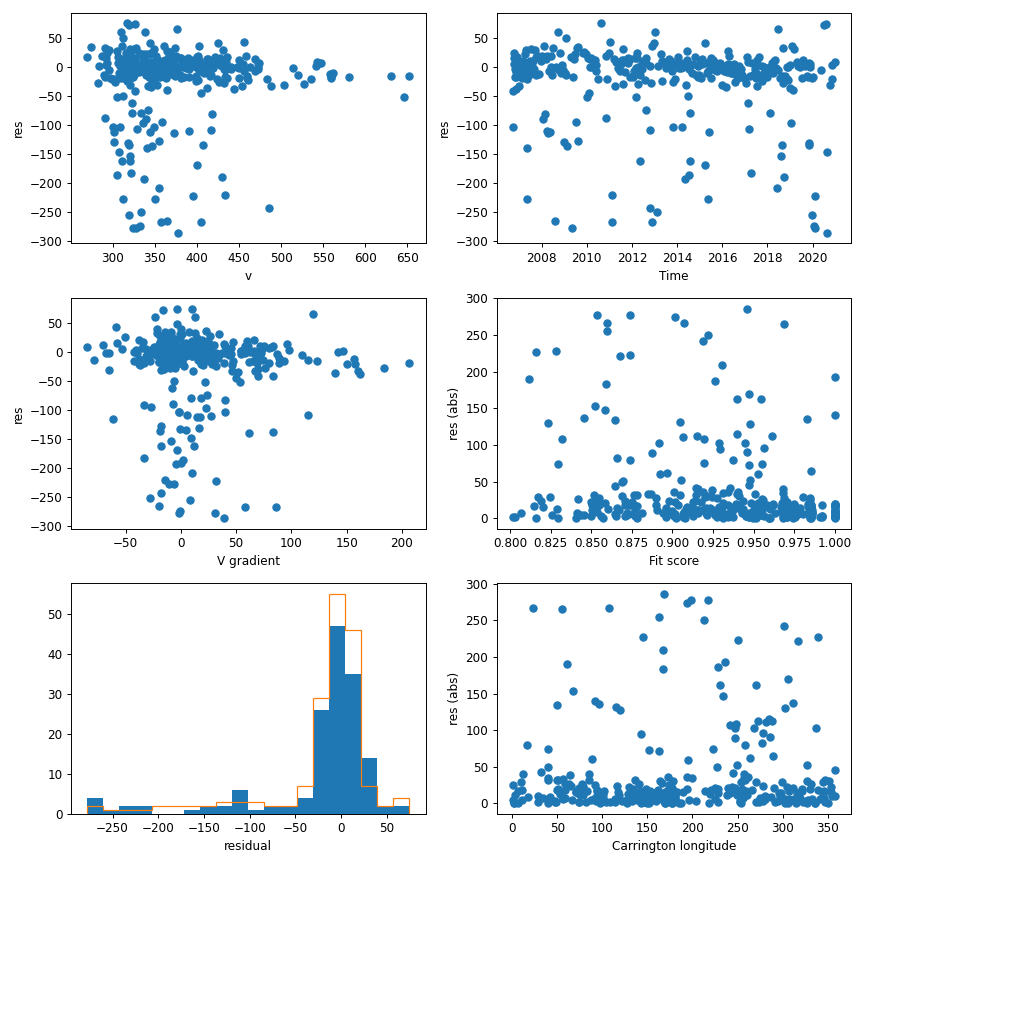

C:\Users\sj919119\AppData\Local\Continuum\anaconda3\envs\heliomapsk\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\sj919119\AppData\Local\Continuum\anaconda3\envs\heliomapsk\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [139]:
# a check for any trend between the mapping residual and the HCS properties
res = sec_df.dphi_con.values-sec_df.lon_shift.values.astype(float)

shape = [3,2]
plt.figure(figsize=(10,10))
plt.subplot(shape[0],shape[1],1)
plt.scatter(sec_df.V,res)
plt.xlabel('v')
plt.ylabel('res')
# plt.ylim(-50,50)
plt.subplot(shape[0],shape[1],2)
plt.scatter(sec_df.index,res)
plt.xlabel('Time')
plt.ylabel('res')
plt.subplot(shape[0],shape[1],3)
plt.scatter(sec_df.Vgrad,res)
plt.xlabel('V gradient')
plt.ylabel('res')
plt.subplot(shape[0],shape[1],4)
plt.scatter(sec_df.score,abs(res))
plt.xlabel('Fit score')
plt.ylabel('res (abs)')
plt.subplot(shape[0],shape[1],5)
a=plt.hist(res[sec_df.flip=='+'],bins=20)
plt.hist(res[sec_df.flip=='-'],histtype='step',bins=a[1])
plt.xlabel('residual')
plt.subplot(shape[0],shape[1],6)
plt.scatter(sec_df.CarLon,abs(res))
# plt.hist(sec_df.CarLon,histtype='step',color='C1')
plt.xlabel('Carrington longitude')
plt.ylabel('res (abs)')
plt.tight_layout()

ote that there isn't a lot of predictability here. In particular we don't get an agreement looking at the neugebauer stuff 

<IPython.core.display.Javascript object>


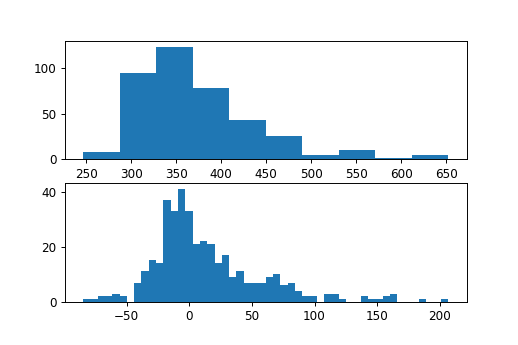

(array([ 1.,  1.,  2.,  2.,  3.,  2.,  0.,  7., 11., 15., 14., 37., 33.,
        41., 33., 21., 22., 21., 14., 17.,  9., 11.,  7.,  7.,  7.,  9.,
        10.,  6.,  7.,  4.,  2.,  2.,  0.,  3.,  3.,  1.,  0.,  0.,  2.,
         1.,  1.,  2.,  3.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([-84.66665649, -78.83998962, -73.01332275, -67.18665588,
        -61.35998901, -55.53332214, -49.70665527, -43.8799884 ,
        -38.05332153, -32.22665466, -26.39998779, -20.57332092,
        -14.74665405,  -8.91998718,  -3.09332031,   2.73334656,
          8.56001343,  14.3866803 ,  20.21334717,  26.04001404,
         31.86668091,  37.69334778,  43.52001465,  49.34668152,
         55.17334839,  61.00001526,  66.82668213,  72.653349  ,
         78.48001587,  84.30668274,  90.13334961,  95.96001648,
        101.78668335, 107.61335022, 113.44001709, 119.26668396,
        125.09335083, 130.9200177 , 136.74668457, 142.57335144,
        148.40001831, 154.22668518, 160.05335205, 165.88001892,
        171.

In [129]:
# a look at the speed and velocity gradients associated with the crossings
plt.figure()
plt.subplot(211)
plt.hist(sec_df.V.values)
plt.subplot(212)
plt.hist(sec_df.Vgrad.values,bins=50)


<IPython.core.display.Javascript object>


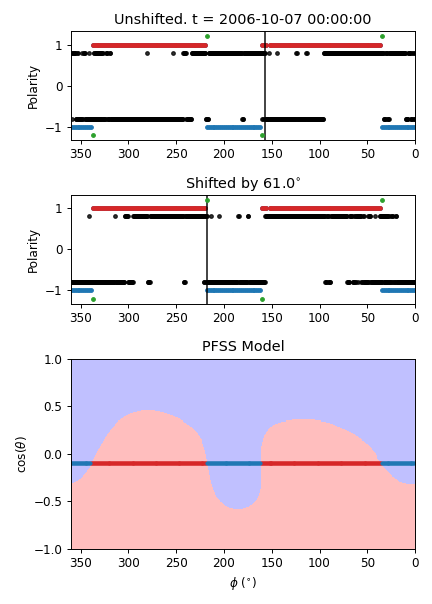

<ipython-input-134-2acc2c88fe66>:67: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


In [134]:
# 1D comparison. This is a paper plot.

# Paper uses i = 2 

import matplotlib.gridspec as gridspec
tlistuse = sec_df.index[np.isfinite(sec_df.lon_shift)]
i = choice(np.arange(0,tlistuse.size))
i=2
t = tlistuse[i]

dat_ind = abs(t - dat.index) < pd.Timedelta('14D')

fig = plt.figure(figsize=(5,7),constrained_layout=2)
gs = gridspec.GridSpec(ncols=1, nrows=7, figure=fig)

p=dfss.loc[t].pol.values

ax1=plt.subplot(gs[0:2, 0])
plt.title(f'Unshifted. t = {t}')
plt.plot(dfss.loc[t].lon,dfss.loc[t].pol,'.')
plt.plot(dfss.loc[t].lon[p>0],dfss.loc[t].pol[p>0],'.',color='C3')
plt.plot(dat.CarLon[dat_ind],dat.park_pol[dat_ind]*.8,'.',color='k',alpha=.8)
plt.axvline(sec_df.loc[t].lon_cross,color='k',alpha=.8)
plt.plot(dfss.loc[t].lon[dfss.loc[t].flipsign!=0],dfss.loc[t].flipsign[dfss.loc[t].flipsign != 0]*1.2,'.',color='C2')


plt.yticks([-1,0,1])
plt.xlim(360,0)
plt.ylabel('Polarity')

plt.subplot(gs[2:4, 0])
plt.title(f'Shifted by {sec_df.loc[t].lon_shift:.1f}'+'$^{\circ}$')
plt.plot(dfss.loc[t].lon,dfss.loc[t].pol,'.')
plt.plot(dfss.loc[t].lon[p>0],dfss.loc[t].pol[p>0],'.',color='C3')
plt.plot(re_angle_deg(dat.CarLon[dat_ind].values+sec_df.loc[t].lon_shift,0,360),dat.park_pol[dat_ind]*.8,'.',color='k',alpha=.8)
plt.axvline(sec_df.loc[t].lon_cross+sec_df.loc[t].lon_shift,color='k',alpha=.8)
# plt.axvline(sec_df.loc[t].lon_cross+sec_df.loc[t].dphi_con,color='C3')
plt.plot(dfss.loc[t].lon[dfss.loc[t].flipsign!=0],dfss.loc[t].flipsign[dfss.loc[t].flipsign != 0]*1.2,'.',color='C2')
plt.xlim(360,0)
plt.ylabel('Polarity')
plt.yticks([-1,0,1])

# plot on here the model data too
plt.subplot(gs[4:7, 0],sharex=ax1)
timerange = time_model[i] + pd.to_timedelta(np.linspace(0,27.3,360),unit='days')
eartheph = ephemeris.get_earth(time=timerange)
lats = eartheph.lat
lons=sun.L0(time=timerange)

# now produce a polarity profile along these longitudes and plot on top to verify
t =df_gong_a.loc[t].gongtime

pfss_ = open_pfss_from_t(t)

output = pfss_.output

br = br_check(np.cos(np.pi/2+lats.value*np.pi/180.),lons.value*np.pi/180,pfss_.costheta,pfss_.phi,pfss_.ssbr)

costhetagrid,longrid=np.meshgrid(pfss_.costheta,pfss_.phi)
mesh = plt.pcolormesh(longrid*180./np.pi,costhetagrid,np.sign(pfss_.ssbr.T),cmap=plt.get_cmap('bwr'),vmin=-4,vmax=4)
# plt.colorbar()
plt.scatter(lons.value[br>0],np.cos(np.pi/2+lats.value*np.pi/180.)[br>0]*0-.1,color='C3',s=6)
plt.scatter(lons.value[br<0],np.cos(np.pi/2+lats.value*np.pi/180.)[br<0]*0-.1,color='C0',s=6)
plt.xlabel('$\phi$ ($^{\circ}$)')
plt.title('PFSS Model')
plt.ylabel(r'cos($\theta$)')
plt.tight_layout()

plt.savefig('pfss_insitu_match_example.pdf')